# Notebook de test des données lapi brutes

In [1]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import donnees_brutes as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os, math
from sklearn.cluster import DBSCAN

# 1. import des données, traitement de mise en forme
## 1.1 Import

In [3]:
%time df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')

Wall time: 55.7 s


In [5]:
df_3semaines=df_3semaines.set_index('created').sort_index()

In [88]:
#plaques non chiffrees
df_plaque=t.ouvrir_fichier_lapi_final()

In [89]:
df_plaque.head(5)

plaque_ouverte                                  chiffree
0        BC468BP  3d30c86fdaf2bb6282f43e61064cebb48d88b71b
1        EH088HA  856e29fc536fa33c92c2a77ccf37fa85b5662a6d
2        EV275JN  9692677c35e067c87adafabc3b5c3eb599e06330
3        EV162KN  ea5d83d986acde36cba2844a693e092ab3d9c5c1
4        EY476FY  a8d319e321926393b535b33d11d271ac40a5dce2

## 1.2 Traitement des doublons
### 1.2.1 Doublons (mm camera mm immat, mm temps ou tres proches (<10s))

In [90]:
#trouver les doublons
#doublons=df_3semaines.reset_index()
#doublons.loc[doublons.duplicated(['created','immat'],keep=False)]
#supprimer les doublons
df_3semaines=df_3semaines.reset_index().drop_duplicates(['created','immat'])

#doublons "proches" : même immat, même camera, passages écartés de moins de 10s
df_3semaines=df_3semaines.sort_values(['immat','created','camera_id','fiability']).copy()
df_3semaines['id']=(df_3semaines.created - df_3semaines.created.shift(1) > pd.Timedelta(seconds=10)).fillna(99999999).cumsum(skipna=False)
df_3semaines=df_3semaines.sort_values(['immat','id','fiability'], ascending=False).copy().drop_duplicates(['immat','id']).set_index('created')

### 1.2.1 passages rapproches (mm immat, temps proches (<5min), cam differentes)
> Regrouper les passages

In [159]:
%time groupe_pl_rappro, groupe_pl=t.passages_proches(df_3semaines)

Wall time: 9min 52s


>Tests possibles

In [107]:
#obtenir le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()

In [ ]:
#nb de plaques avec un passage de faibilite inférieur à 50
groupe_pl_rappro.loc[groupe_pl_rappro.apply(lambda x : any(e<50 for e in x['fiability_faux']),axis=1)]

In [ ]:
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux','fiability_faux']]

In [ ]:
#jointure avec plaques réelles 
groupe_pl_rappro.merge(df_plaque, left_index=True, right_on='chiffree')

>**Analyse des données**

In [161]:
jointure = t.analyse_passage_proches(groupe_pl_rappro, groupe_pl)

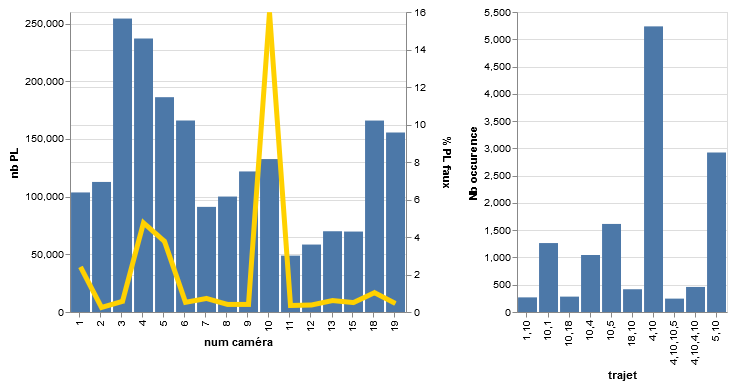

In [195]:
t.graph_passages_proches(jointure, groupe_pl_rappro)

##### ***Traiter les données***

In [75]:
#filtrer le df_3semaines selon les passages trop proches, ou juste les passages trop proche de fiabilité foiriruse : 
df_3semaine_filtre=df_3semaines.loc[~df_3semaines.reset_index().set_index(['immat', 'camera_id','created']).index.isin(
                                    df_passage_rapproches.set_index(['immat', 'camera_id','created']).index.tolist())]

# 2. Création des trajets
## 2.1 Listes des trajets
>Listes créées à la main au départ, puis sauvegardée dans un fichier json.<br> Contient la liste des trajets "complet" i.e avec la camera de début et de fin, et la liste des trajets "incomplet" i.e où il peut manquer la camera de debut ou de fin (**attention, pour le moement le cas de A63 est traité à part pour le cas incomplet, car en fait les cas incomplet A63 renvoi un trajet de transit qui s'arrete à A660**).<br> on ajoute ensuite les données de longueur et tempsdeparcours théorique, sur la base d'un vitesse pl motyenne de 80 km/h pour vavoir un peu de marge

In [7]:
liste_complete_trajet=pd.read_json(r'E:\Boulot\lapi\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [ ]:
liste_trajet_incomplet=pd.DataFrame(np.array([[4, 15, (15,19,4), 'N10',85.048763,3,'A63-N10','A63','01:03:47.194000'], 
                                              [1, 15, (15,19,1), 'N10',89.925738,3,'A63-N10','A63','01:07:26.658000'],
                                              [4, 15, (15,4), 'N10',85.048763,2,'A63-N10','A63','01:03:47.194000'],
                                              [1, 15, (15,1), 'N10',89.925738,2,'A63-N10','A63','01:07:26.658000'],
                                              [4, 15, (15,19,4), 'A89',90.709158,3,'A63-A89','A63','01:08:01.912000'],
                                              [4, 15, (15,4), 'A89',90.709158,2,'A63-A89','A63','01:08:01.912000'],
                                              [19, 15, (15,19), 'A62',73.187282,2,'A63-A62','A63','00:54:53.427000'],
                                              [4, 10, (10,4), 'N10',29.693103,2,'A62-N10','A62','00:22:16.189000'],
                                              [4, 10, (10,4), 'A89',35.353498,2,'A62-A89','A62','00:26:30.907000'],
                                              [6, 12, (12,6), 'A89',43.113096,2,'A10-A89','A10','00:32:20.089000'],
                                              [3, 12, (12,6,3), 'A62',50.013745,3,'A10-A62','A10','00:37:30.618000'],
                                              [3, 8, (8,3), 'A62',36.003136,2,'A89-A62','A89','00:27:00.141000'],
                                              [3, 6, (6,3), 'A62',30.230090,2,'N10-A62','N10','00:22:40.354000']
                                             ]),
                                    columns=['cam_d', 'cam_o', 'cameras','destination', 'long_km', 'nb_cams','o_d', 'origine', 'tps_parcours_theoriq'])
#liste_trajet_incomplet.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\liste_trajet_incomplet.json', orient='index')
liste_trajet_incomplet=pd.read_json(r'E:\Boulot\lapi\liste_trajet_incomplet.json', orient='index')
liste_trajet_incomplet['cameras']=liste_trajet_incomplet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_trajet_incomplet['tps_parcours_theoriq']=liste_trajet_incomplet.apply(lambda x : pd.Timedelta(x['tps_parcours_theoriq']),axis=1)
liste_trajet_incomplet.sort_values('nb_cams', ascending=False, inplace=True)

## 2.2 Constitution de la base des trajets de transit
>obtention de 3 dataframes : 
- contenant les trajets de transit
- contenant les passages de transit
- contenant les temps maxi autorisés pour etre considéré comme transit, et le type detems maxi (cluster ou reglementaire)

### 2.2.1. Base : trajets qui collent avec ceux prévus dans la liste des trajets

In [6]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-28 00:00:00',7,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-05-10 15:57:16.708144
date : 2019-01-29 00:00:00 debut_traitement : 2019-05-10 15:58:17.597246
date : 2019-01-30 00:00:00 debut_traitement : 2019-05-10 15:59:28.871343
date : 2019-01-31 00:00:00 debut_traitement : 2019-05-10 16:00:39.261914
date : 2019-02-01 00:00:00 debut_traitement : 2019-05-10 16:02:02.792386
date : 2019-02-02 00:00:00 debut_traitement : 2019-05-10 16:03:38.400586
date : 2019-02-03 00:00:00 debut_traitement : 2019-05-10 16:05:09.487722


*important : controle si doublons entre trajets*.<br> pourrait faire l'objet d'une fonction supp

In [ ]:
for destination in ['N10','A10','A63','A660', 'A89', 'A62'] : 
    print (t.verif_doublons_trajet(dico_od, destination))

### 2.2.2. Filtrer les trajets selon un temps de parcours
> Lorsque l'on utilise transit_temps_complet, le dico de stemps max est crée (On regroupe les trajets par Cluster, on utilise une df des parametres à utiliser pour les cluster basée sur des observations perso et un travail à la main). <br> En premier lieu on corrige ce dico des temps max en prenant un moyenne des temps max de type Cluster lorsque ceux ci encadre un temps max de type '85_percentile). <br> Là, on met un attribut drapeau pour identifier les trajets de transit.<br> la fonction graph_transit_filtre_multiple permet de visualiser les trajets de transit sur plusieurs jours, pour une o_d

In [35]:
#pour info : parametres cluster
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')
param_cluster

delai  nb_pt_min  temps_etudie  \
0    600          4            15   
1   1200          4            60   
2    800          3            15   
3   1000          4            60   
4   1000          4            15   

                                                                                                                      trajet  
0           [A10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
1  [A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
2  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]  
3  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]  
4                                                                                                                    N10-A63

In [7]:
#dico des temps max issus du lapi corrigé avec moyenne cluster
dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

In [9]:
# df complete avec l'atribut filtre
df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

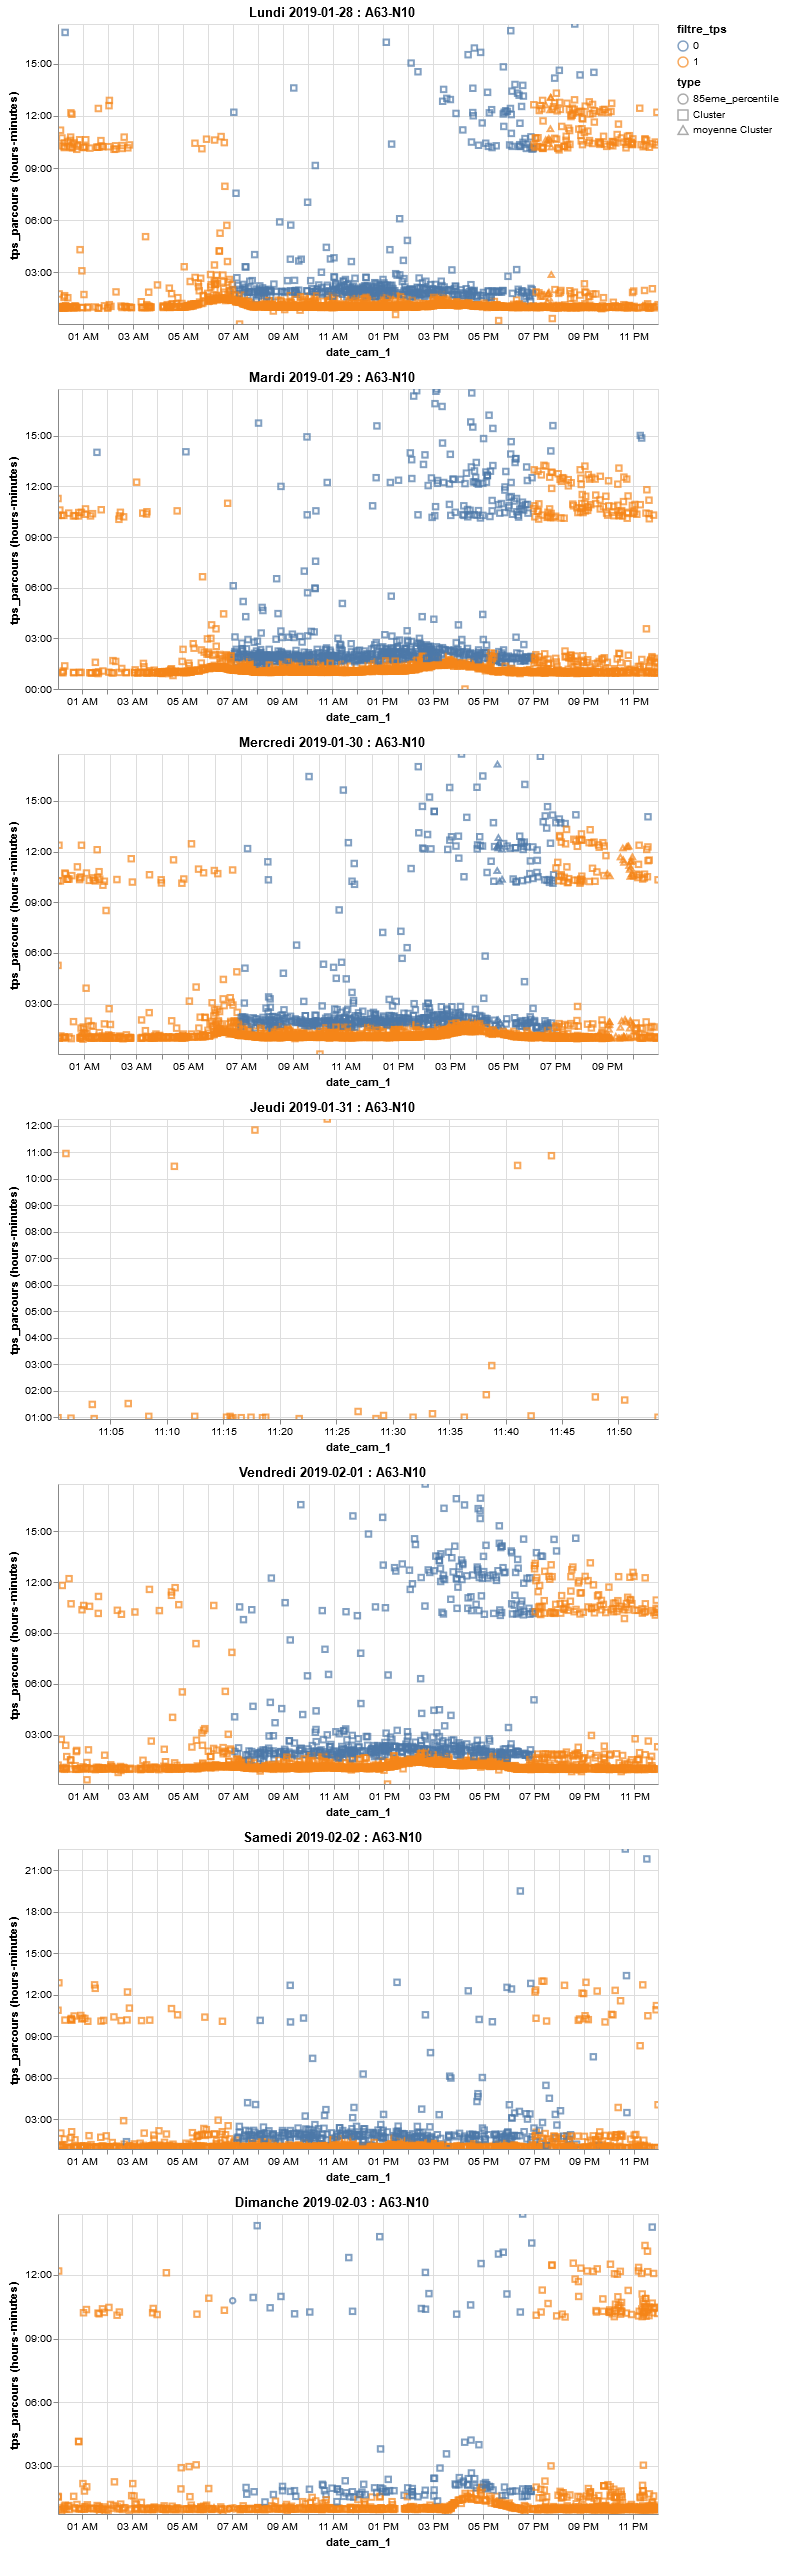

In [10]:
#exemple de visu sur 7 jours
t.graph_transit_filtre_multiple(df_transit_avec_filtre, 
                                '2019-01-28 00:00:00', '2019-01-28 23:59:59', 'A63-N10', 7)

In [38]:
#filtrer le df : 
dico_od_final=df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]

### 2.2.3. Correction des trajets depuis ou vers A660 relatifs à A63
> Il s'agit de corriger les trajets référencé depouis ou vers A660, alors que le vehicules a du passer sur A63 aussi.<br> plusieurs cas : 
- Passer sur A660 et vu avant ou apres sur A63
- Passer que sur A660 dans le sens nord sud puis sud-Nord, avec une immat déja vudans les plaques de transit et plus de 1jours d'ecart entre les passages

In [ ]:
#### A VERIFIER !!!!
%time df_od_corrige=t.correction_trajet(df_3semaines, dico_od_final)
#pour exemple
#df_od_corrige=dico_od_final.copy()
#df_od_corrige['correction_o_d']=False

In [ ]:
#pour retrouver les trajets corrigé : 
df_od_corrige.loc[df_od_corrige['correction_o_d']==True]

### 2.2.4. extrapolation des trajets non complets
> pour les véhicules qui ont déja été identifié comme faisant du transit.**<br>Attention : <br>ce travail se base sur le fait qu'un véhicule qui parcoure un trajet incomplet doit forcément revenir sur le dispositif par un point d'entrée LAPI(cam 15,6,8,10,12)**<br>*un test pourrait etre mené pour illustrer le nb de pl qui ne font pas de transit : cf ligne de code :* <br>#POUR TEST !!!!!<br> #trajet_transit_incomplet=trajets_possible_enrichi <br>de la fonction transit_trajet_incomplet

In [ ]:
#creer les donnees necessaires
%time df_filtre_A63,df_passage_transit,df_non_transit=t.param_trajet_incomplet('2019-01-28 00:00:00',df_od_corrige,df_3semaines,dico_passag)

In [157]:
#trajet de transit incomplet sans filtre sur temps de parcours
%time trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,df_non_transit,'2019-01-28 00:00:00',1,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-05-06 17:05:57.323329
Wall time: 43.3 s


In [158]:
trajet_transit_incomplet2

date_cam_1                                     immat state  l  \
0 2019-01-28 00:36:41  94e39baa499f9c4a668b6e4591eb6efd848ccf45    ES  1   
0 2019-01-28 05:00:02  004bb0ee9dc5a6f1651f22537d4127b5379f68e3    FR  1   
0 2019-01-28 13:20:27  eaec81170774b0d1b8c4715d4c2a3316e4cbecdf    FR  1   
0 2019-01-28 14:44:42  f390910ed0c50ca644ffb2b40531ac22d2470cc9    FR  1   

           date_cam_2 o_d_immat  Nb_occ      cameras origine destination  \
0 2019-01-28 01:25:14   A63-N10       2      (15, 4)     A63         N10   
0 2019-01-28 06:41:43   A62-N10       2      (10, 4)     A62         N10   
0 2019-01-28 13:45:42   A10-A62       2   (12, 6, 3)     A10         A62   
0 2019-01-28 15:35:59   A63-N10       3  (15, 19, 4)     A63         N10   

       o_d tps_parcours  cam_suivant        date_suivant  
0  A63-N10     00:48:33          6.0 2019-01-28 15:54:34  
0  A62-N10     01:41:41          6.0 2019-01-28 13:14:10  
0  A10-A62     00:25:15         10.0 2019-01-28 16:36:20  
0  A63-N10     00:51:17          6.0 2019-01-29 07:53:36

In [186]:
#filtrer selon le temps de parcours
trajet_transit_incomplet_filtre_temps=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,liste_trajet_incomplet, 15,'incomplet')
#mettre en forme les attributs
trajet_transit_incomplet_filtre_temps=trajet_transit_incomplet_filtre_temps[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
       'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
       'tps_parcours_theoriq', 'filtre_tps']]
#filtrer le df : 
trajet_transit_incomplet_final=trajet_transit_incomplet_filtre_temps.loc[trajet_transit_incomplet_filtre_temps['filtre_tps']==1]

In [187]:
#ajouter l'attribut d'identification des trajets 
trajet_transit_incomplet_final['correction_o_d']=True
#6. Ajouter au df des o_d précédents : 
df_od_final=pd.concat([df_od_corrige,trajet_transit_incomplet_final])

# 3. CREER LE TABLEAU DE MATRICE O-D

In [40]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination   A10   A62    A63  A660   A89    N10    All
origine                                                 
A10            NC  2763   2402  1618   188     NC   6971
A62          1007    NC    125   522   274   1158   3086
A63          1782    88     NC    NC   479  11113  13462
A660         1112   471     NC    NC   912   3480   5975
A89           158   414    751  1088    NC     NC   2411
N10            NC  1377   9396  2934    NC     NC  13707
All          4059  5113  12674  6162  1853  15751  45612

## 4. Nb VL, PL et PL en transit par Plage Horaire et caméra

In [120]:
#calcul des nb vl, pl et PL en transit par heure et camera
test=t.pourcentage_pl_camera(df_3semaines,dico_passag)

In [123]:
#selection df pour graphique
pour_graph=jointure_pct_pl.loc[(test.apply(lambda x : x['created'].dayofyear==pd.to_datetime('2019-01-31').dayofyear,axis=1))
                              &(test['camera_id']==4)]

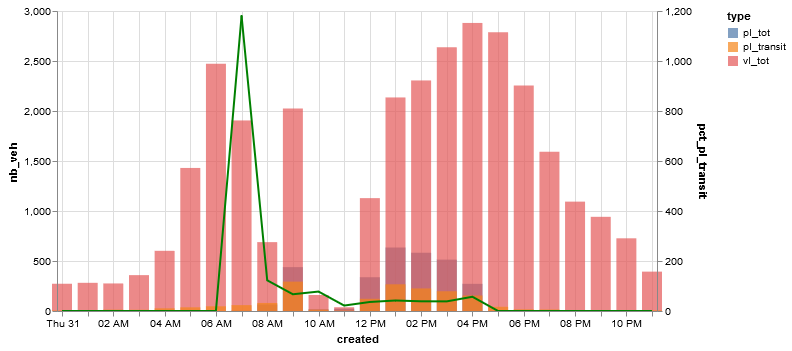

In [122]:
#graphique
base=alt.Chart(pour_graph).encode(x='created')
bar = base.mark_bar(opacity=0.7, size=20).encode(y=alt.Y('nb_veh:Q',stack=None),color='type')
line=base.mark_line(color='green').encode(y='pct_pl_transit:Q')
(bar+line).resolve_scale(y='independent').properties(width=600)

VERIFICATION

In [97]:
#retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='004ff1699a6838eb11686af6107def0202a8b69b'].sort_index()

index  camera_id  \
created                                   
2019-01-28 10:16:23   166858          9   
2019-01-28 10:20:00   220380         10   
2019-01-29 10:19:58   244105         10   
2019-01-29 10:31:49   738500          4   
2019-01-31 09:32:22  1155456          4   
2019-01-31 09:36:18  1013264         10   
2019-01-31 09:42:22   867949          5   
2019-01-31 10:01:42  1034817         11   
2019-01-31 14:27:57  1049060         12   
2019-01-31 14:38:43   912945          6   

                                                        immat  fiability  l  \
created                                                                       
2019-01-28 10:16:23  004ff1699a6838eb11686af6107def0202a8b69b         99  0   
2019-01-28 10:20:00  004ff1699a6838eb11686af6107def0202a8b69b         89  0   
2019-01-29 10:19:58  004ff1699a6838eb11686af6107def0202a8b69b         79  0   
2019-01-29 10:31:49  004ff1699a6838eb11686af6107def0202a8b69b         99  0   
2019-01-31 09:32:22  004ff1699a6838eb11686af6107def0202a8b69b         89  0   
2019-01-31 09:36:18  004ff1699a6838eb11686af6107def0202a8b69b         99  0   
2019-01-31 09:42:22  004ff1699a6838eb11686af6107def0202a8b69b         99  0   
2019-01-31 10:01:42  004ff1699a6838eb11686af6107def0202a8b69b         99  0   
2019-01-31 14:27:57  004ff1699a6838eb11686af6107def0202a8b69b         99  1   
2019-01-31 14:38:43  004ff1699a6838eb11686af6107def0202a8b69b         99  0   

                    state    id  
created                          
2019-01-28 10:16:23    FR  4851  
2019-01-28 10:20:00    FR  4852  
2019-01-29 10:19:58    FR  4853  
2019-01-29 10:31:49    FR  4854  
2019-01-31 09:32:22    FR  4855  
2019-01-31 09:36:18    FR  4856  
2019-01-31 09:42:22    FR  4857  
2019-01-31 10:01:42    FR  4858  
2019-01-31 14:27:57    FR  4859  
2019-01-31 14:38:43    FR  4860

In [84]:
#retrouver les cameras et date avant / apres un passage
def cam_voisines(immat, date, camera, df_immat) :
    """
    Retrouver les dates et camera de passages d'un vehicule avant et apres un passage donne
    en entree : 
        immat : string : immatribualtion
        date : string : date de passage
        camera : cam de passage
        df_immat : df des immats concernees (limiter le df_3semainee)
    """
    passage_immat=df_immat.loc[df_immat['immat']==immat].reset_index().copy()
    idx=passage_immat.loc[(passage_immat['created']==date) & (passage_immat['camera_id']==camera)].index
    cam_suivant, date_suivant=passage_immat.shift(-1).iloc[idx]['camera_id'].values[0], passage_immat.shift(-1).iloc[idx]['created'].values[0]
    cam_precedent, date_precedent=passage_immat.shift(1).iloc[idx]['camera_id'].values[0], passage_immat.shift(1).iloc[idx]['created'].values[0]
    return cam_suivant,date_suivant, cam_precedent,date_precedent


In [139]:

toto=df_3semaines.loc[pd.to_datetime('2019-02-01 09:00:00'):pd.to_datetime('2019-02-04 22:00:00')]
toto.loc[toto['camera_id']==11]

camera_id                                     immat  \
created                                                                    
2019-02-01 23:00:51         11  a1a9148b72647a6aeb97219e0ece325b04a18c18   
2019-02-01 23:01:35         11  0a6309f51c40e3dba00b441dbb8c1a5a784e4c6a   
2019-02-01 23:01:47         11  bd9b1bc1bd72453a41baae0909a40aea0e009e4f   
2019-02-01 23:02:04         11  b2fe2ec5da89e6a74424375fdedd88ce4c83e87e   
2019-02-01 23:02:24         11  55dce112f48dc9811d985e9ed11b9d0ea7caf442   
2019-02-01 23:02:37         11  d9498bd1085e16e8e534abbc47f2ff78bacfdffe   
2019-02-01 23:04:15         11  9f45540c24b3534beb0beeae7d597de5f63f67ac   
2019-02-01 23:04:55         11  a895e9993249b44e116002dad11030555b53b657   
2019-02-01 23:05:28         11  6424572aa102be183ac14bcbcd1ded817fc1a79d   
2019-02-01 23:07:24         11  622af09fb626586a901eb0646b32438efba4bdd4   
2019-02-01 23:09:28         11  ee3fe3d8d2ce5e713feecca3809c19c508ddb57f   
2019-02-01 23:10:43         11  801d5049aee2e45c792d9d42a049bb73aeccc76c   
2019-02-01 23:11:51         11  d2015be4d83017ce75cc0616fe210ecefdf21588   
2019-02-01 23:11:57         11  e9139e920f9851b7bc501dc88fd5072fb18d90d2   
2019-02-01 23:12:30         11  56e324e928bc3de65d6adc4f0bfc87286d9f481a   
2019-02-01 23:12:53         11  62a2ed1a3a2800e3adbf9cb14cc8021ea01f2fda   
2019-02-01 23:13:40         11  e7f1be7ba85826b1127a04182341399df82dc88f   
2019-02-01 23:13:47         11  3b0bb2f1e179feaf1dcce12b01d48f2473d7f026   
2019-02-01 23:15:12         11  6e1835f5256c615f2db83dcb84b08f50c7f32024   
2019-02-01 23:15:18         11  06e17dd9b5adf1c7f7920f7d02f5dc8fb6f0d9e8   
2019-02-01 23:16:34         11  31d6350cbb9a27f8a2a4a29ef1a32fdc7e54e42d   
2019-02-01 23:16:56         11  5deff94873856738abb7cd208b8af5d0b683472e   
2019-02-01 23:17:00         11  06f74dba512c325b6d458a05d59c899c75394418   
2019-02-01 23:17:40         11  b60ace1d3a40265288030fd2795b5c3635a847d5   
2019-02-01 23:18:26         11  b86a24b6c70a03836e41128e39d036ae83e56b6b   
2019-02-01 23:18:48         11  304c0990739fbcfc268061580f0ca09e5030a959   
2019-02-01 23:19:13         11  61ca90c70ab6aa7c07e02a2e2eaedf2fbe77c3d2   
2019-02-01 23:19:55         11  9d2ebc07b0ec3fc7ac65d1bed3ee62007f62661b   
2019-02-01 23:19:57         11  f35ad69395bd10662e83d48e53c2e988cc2864c0   
2019-02-01 23:21:45         11  3cec83f04c2294fa44a4af2af8f2215032f86f2d   
...                        ...                                       ...   
2019-02-04 21:46:35         11  15e10557ad775743af5f48cfc1ae230254c09085   
2019-02-04 21:47:09         11  5d529c34ff5592fd57d2385cde0ac7cc04cc79bc   
2019-02-04 21:47:46         11  efb48ae2124f10b77dfc6b75e5c81c5ba6d6af1c   
2019-02-04 21:47:50         11  6c9f8548f5f3dba20ee00c92dce39dbf24b5c357   
2019-02-04 21:48:38         11  7186f27b5b65dea06874f08754741800f225f866   
2019-02-04 21:48:56         11  d2ec1ecdf4b8a241847b143a73323bea9cff51d5   
2019-02-04 21:49:36         11  9504f142239b54a5c24354b6291138d22b5abef2   
2019-02-04 21:49:53         11  df5a038bd8b3643bd0f7842d2fad2bb4be290b53   
2019-02-04 21:49:57         11  8f0c0642aadcfe321c56ea0aa697c79cd4a9bd26   
2019-02-04 21:49:58         11  e3b6effff4ce5a554417f52dda91cc75f9048915   
2019-02-04 21:50:08         11  d97c4211d0e3714ad341c9eaacf50e47d195332a   
2019-02-04 21:50:38         11  73a4309acf3bbd978208164d290933eeb9c05814   
2019-02-04 21:51:22         11  f4223facd13a71e8c143e88d76155e3e70f878e4   
2019-02-04 21:52:10         11  0378fd58e1d82c0950ac5a8cc743c8f905896518   
2019-02-04 21:52:24         11  8e5aa2d30010ee9da5a54cd2c00c1224969c1e1e   
2019-02-04 21:52:59         11  4e74c92d55807f781d9cdc830b7fa9a8c3457bd1   
2019-02-04 21:53:31         11  44d33cc791b4a92e3837b08090574357ee726214   
2019-02-04 21:54:38         11  bd46f9745ff1c34012b63c10c532395e52c0014f   
2019-02-04 21:56:29         11  14fb4e903f8deebd3e316d76d58ca741e49f84a9   
2019-02-04 21:56:33         11  053e28467dd7fda110de7adeb237eaa29da98

In [54]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0']

date_cam_1                                     immat state  l  \
18 2019-01-29 07:44:45  b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0    ES  1   

            date_cam_2      cameras origine destination      o_d tps_parcours  \
18 2019-01-29 09:10:44  (6, 18, 13)     N10         A63  N10-A63     01:25:59   

              period  
18  2019-01-29 07:30

In [130]:
#verif a un horaire donne sur un trajet direct ou indirect ou global
#%time trajet_test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19],modeRegroupement='aucun')
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-02-01 00:00:00':'2019-02-02 23:59:59'], '2019-02-01 09:00:00', 60, [15, 11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
test.df_transit.loc[test.df_transit['o_d']=='A63-A10']

Empty DataFrame
Columns: [date_cam_1, immat, state, l, date_cam_2, cameras, origine, destination, o_d, tps_parcours]
Index: []

TESTS A LA MANO

In [240]:
#pour trouver un trajet direct (sans disticntion de type ou autre)
test2=t.trouver_passages_consecutif(df_3semaines, '2019-01-29 00:00:00', '2019-01-29 23:59:59', 15, 19)
#test2=test2.set_index('created_y').sort_index()

TESTS

In [16]:
a660_n10=dico_od.loc[dico_od['o_d']=='N10-A63'].copy()
a660_n10=a660_n10[a660_n10.apply(lambda x : x['date_cam_1'].to_period('D')==pd.Period('2019-01-29',freq='D'), axis=1)].reset_index().drop('index', axis=1)
a660_n10.tps_parcours=pd.to_datetime('2018-01-28')+a660_n10.tps_parcours

In [17]:
dico_od_graph=dico_od.copy()
dico_od_graph.tps_parcours=pd.to_datetime('2019-01-29')+dico_od_graph.tps_parcours

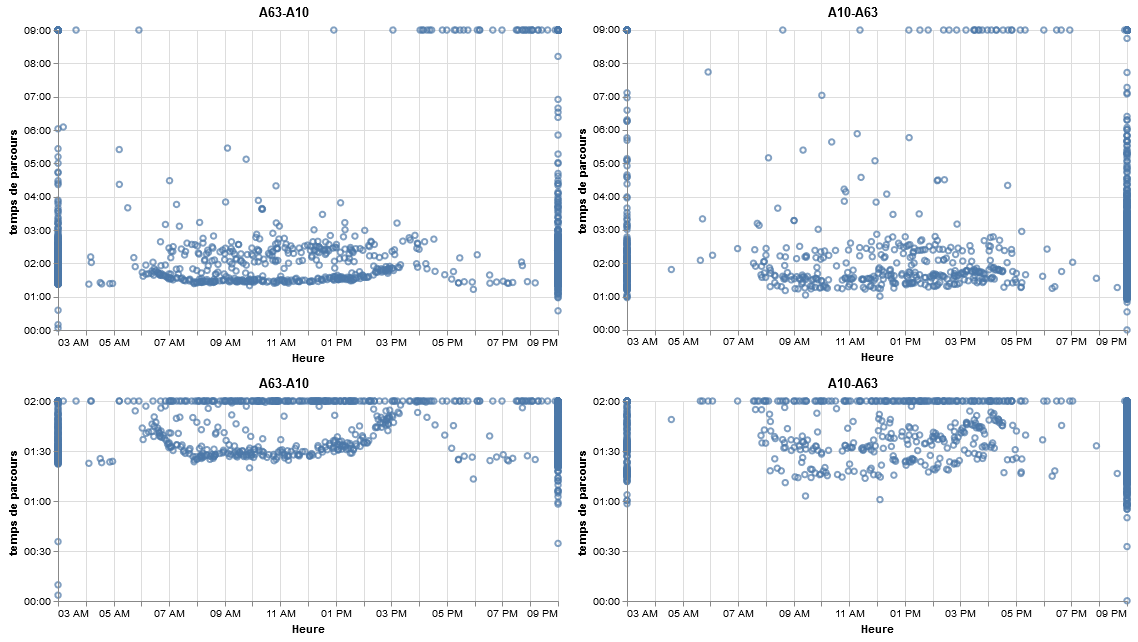

In [20]:
base_a63_n10 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A10-A63'], title='A10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
a63_n10=alt.vconcat(up_a63_n10,low_a63_n10)

base_n10_a63 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A63-A10'], title='A63-A10').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
n10_a63=alt.vconcat(up_n10_a63,low_n10_a63)
n10_a63|a63_n10

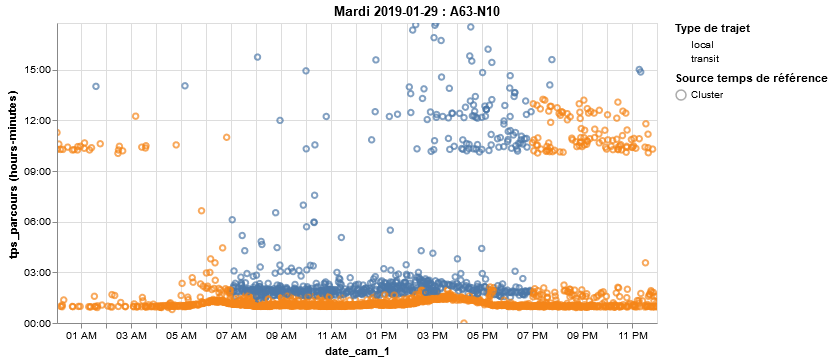

In [25]:
t.graph_transit_filtre(df_transit_avec_filtre,  '2019-01-29 00:00:00', '2019-01-29 23:59:59', 'A63-N10')